# Bilevel ROF Scalar Parameter Learning
In this notebook we will propose an optimal parameter learning methodology for getting the optimal parameter for the scalar ROF image denoising model.

$$
\min \|\bar{u}-z\|^2 + \frac{\alpha}{2}\|\lambda\|^2\\
\text{s.t. }\lambda \langle \bar{u},v-\bar{u} \rangle + \|\mathbb{K}v\|_{2,1} - \|\mathbb{K}\bar{u}\|_{2,1} \ge \langle f,v-\bar{u} \rangle
$$

where $\|\cdot\|_{2,1}$ is the Total Variation seminorm.

In [1]:
using LinearAlgebra, StructuredOptimization, AbstractOperators, Plots, Distributed, Images, ImageQualityIndexes

## Cost Function and Lower Level Solver

In [66]:
# Lower Level Solver
function lower_level_solver(u,f,λ,K)
    @minimize λ*ls(-(1/λ)*K'*u+f) + conj(norm(u,2,1,2)) with ForwardBackward(tol = 1e-6, gamma = 1/8, fast = true) 
    return -(1/λ)*K'*(~u)+f
end

# Upper level cost
function upper_level_cost(u,z,λ,α)
    return 0.5*norm(u[:]-z[:])^2 + 0.5*α*norm(λ)^2 #PSNR
end

upper_level_cost (generic function with 1 method)

In [90]:
m,n = 32,32
f = tril(ones(m,n)) + 0.2*randn(m,n)
f[f .< 0] .= 0.
f[f .> 1] .= 1.
z = tril(ones(m,n));

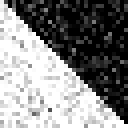

In [91]:
Gray.(f)

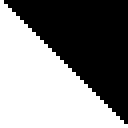

In [92]:
Gray.(z)

In [93]:
K = Variation(size(f))
u = Variable(size(K,1)...)
α = 1e-2

0.01

0.5675190600300712, 5.821907559037308
0.27781438267156516, 9.982095706813277


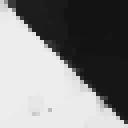

In [95]:
u_h = lower_level_solver(u,f,8,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,10,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,10,α))")
Gray.(u_h)

In [116]:
step = 0.001
lambda_min = 9.4
lambda_max = 9.6
lambda_range = lambda_min:step:lambda_max
costs = Float64[]
ssims = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    push!(costs,upper_level_cost(u_h,z,λ,α))
    push!(ssims,ssim(u_h,z))
    if λ == lambda_range[end]
        print("$(round(λ,digits=3)), ")
    end
end

9.6, 

Task (done) @0x00000001136ecd90

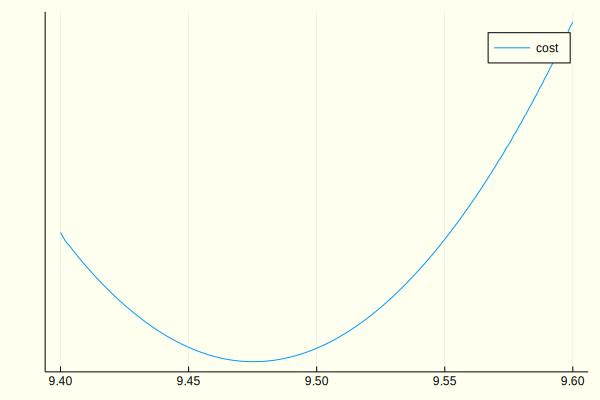

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/dvillacis/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/dvillacis/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/dvillacis/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/dvillacis/.julia/packages/PlotUtils/EybJR/src/ticks.jl:168


In [118]:
plot(lambda_range,costs,label="cost",xticks = 0:0.05:lambda_max, background_color = :ivory)

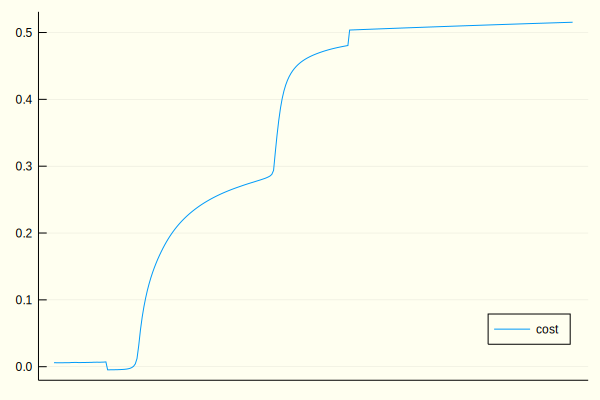

In [103]:
plot(lambda_range,ssims,label="cost",xticks = 0:2:lambda_max, background_color = :ivory, legend=:bottomright)

## Gradient Calculation
Let us consider a reduced cost function

$$
j(\lambda) = \frac{1}{2}\|S(\lambda)-z\|^2+\frac{\alpha}{2}\|\lambda\|^2,
$$

its directional derivative will be given by

$$
j'(\lambda)h = \langle S(\lambda)-z, S'(\lambda)h \rangle + \alpha \langle \lambda, h \rangle
$$

In [11]:
include("gradient_solver.jl")

gradient_solver (generic function with 1 method)

In [12]:
λ = 2
∇ = gradient_matrix(size(f))
u_h= lower_level_solver(u,f,λ,K)
grad = gradient_solver(u_h,f,z,λ,α,K,∇)

-2.9710885137600314

In [13]:
step = 0.1
lambda_max = 20.0
lambda_min = 0.9
lambda_range = lambda_min:step:lambda_max
grads = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    g = gradient_solver(u_h,f,z,λ,α,K,∇)
    push!(grads,g)
    if λ % 10 == 0
        print("$(round(λ,digits=3)), ")
    end
end

10.0, 20.0, 

Task (done) @0x000000012f24e410

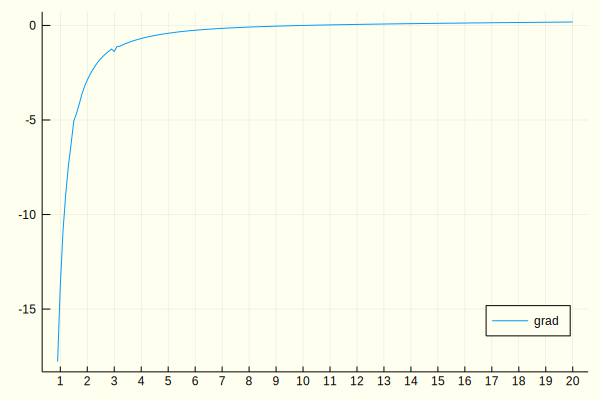

In [14]:
plot(lambda_range,grads,label="grad",xticks = 0:1:lambda_max, background_color = :ivory, legend=:bottomright)
#plot!(lambda_range,costs,label="cost",xticks = 0:5:lambda_max, background_color = :ivory, legend=:bottomright)

## Trust Region Algorithm
We will use a nonsmooth trust region strategy to solve this problem. This method will consider a local quadratic model described by 

$$
q_k(s) = j(\lambda_k)+g_k^\top s + \frac{1}{2}s^\top H_k s
$$

where $s$ is the descent direction, $g_k$ will be the gradient at iteration $k$ and $H_k$ will be a matrix with second order information that can be obtained using SR1 or BFGS method.
The trust region radius will be $\Delta_k$ and the actual and predicted reductions are given by

$$
ared(s_k) := j(\lambda_k)-j(\lambda_k+s_k),\;pred(s_k) := j(\lambda_k)-q_k(s_k)
$$

and the step quality will be given by the following quotient

$$
\rho_k(s_k) = \frac{ared(s_k)}{pred(s_k)}
$$

In [120]:
include("trust_region_solver.jl")

trust_region_solver (generic function with 2 methods)

In [129]:
lambda_0 = 400
radius_0 = 0.1
tol = 1e-6

1.0e-6

In [130]:
model = 1
lambda_opt_1 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model)

9.700001525878907

0.5447872424972139, 5.568247248174986
0.27781438267156516, 9.952545854823542


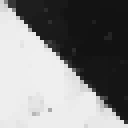

In [132]:
u_h = lower_level_solver(u,f,lambda_opt_1,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,lambda_opt_1,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,lambda_opt_1,α))")
Gray.(u_h)

In [133]:
model = 2 # SR1 Model
lambda_opt_2 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model)

10.15834042024075

0.5381093086659319, 5.580273224372917
0.27781438267156516, 9.998055107280763


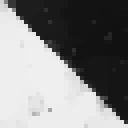

In [134]:
u_h = lower_level_solver(u,f,lambda_opt_2,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,lambda_opt_2,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,lambda_opt_2,α))")
Gray.(u_h)

In [135]:
model = 3
lambda_opt_3 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model)

10.15834042024075

0.5381093082540938, 5.580273224841298
0.27781438267156516, 9.998055107280763


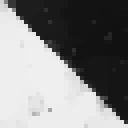

In [136]:
u_h = lower_level_solver(u,f,lambda_opt_3,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,lambda_opt_3,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,lambda_opt_3,α))")
Gray.(u_h)

0.5480135718275991
0.27781438267156516


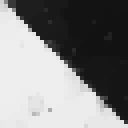

In [131]:
u_h = lower_level_solver(u,f,9.47,K)
println(ssim(u_h,z))
println(ssim(f,z))
Gray.(u_h)